In [2]:
import mysql.connector
import scrapy
from scrapy.crawler import CrawlerProcess
from multiprocessing import Process, Queue
from twisted.internet import reactor
import logging
import re
import time
import html2text
from datetime import datetime
from dateutil import parser
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from scrapy.spidermiddlewares.httperror import HttpError
from twisted.internet.error import DNSLookupError
from twisted.internet.error import TimeoutError, TCPTimedOutError

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
conn = mysql.connector.connect(host='localhost', database='discogs3', user='root', password='root')
cursor = conn.cursor(buffered=True)

def add_artist(*args):
    if type(args[0]) == tuple:
        try:
            print(args[0])
            args[0] = None
            args[0] = 0
        except:
            args[0] = 0
        
    cursor.execute("""SELECT id FROM artist WHERE id="{0}" """.format(args[0]))
    if cursor.fetchone() is None:
        try:
            cursor.execute("""INSERT INTO artist VALUES (%s, %s, %s); """, (args[0], args[1], args[2][:500] if len(args[2]) >= 500 else args[2]))
            conn.commit()
        except Exception as err:
            print('artist', arg[0], err)
            conn.rollback()
        
def add_album(*args, released=True):
    try:
        if released:
            try:
                qwer = parser.parse(args[3])
            except Exception as err:
                qwer = None
            
            cursor.execute("""INSERT INTO album (artist_id, album_name, versions, released, country, rating, format) VALUES (%s, %s, %s, %s, %s, %s, %s)""", (args[0], args[1], args[2], qwer, args[4], args[5], args[6],)) # id, artist_id, name, ver, rel, count, rating
        else:
            cursor.execute("""INSERT INTO album (artist_id, album_name, versions, country, rating, format) VALUES (%s, %s, %s, %s, %s, %s)""", (args[0], args[1], args[2], args[3], args[4], args[5],))

        conn.commit()
        return cursor.lastrowid
    except Exception as err:
        print ('album', args[0], args[1], err)
        conn.rollback()
        
def add_style(*args):
    for s in args[0]:
        if s:
            try:
                cursor.execute("""INSERT INTO album_style (album_id, style) VALUES (%s, %s)""", (args[1], s,))
                conn.commit()
            except Exception as err:
                print ('style', args[1], err)
                conn.rollback()

def add_genre(*args):
    for g in args[0]:
        if g:
            try:
                cursor.execute("""INSERT INTO album_genre (album_id, genre) VALUES (%s, %s)""", (args[1], g,))
                conn.commit()
            except Exception as err:
                print ('genre', args[1], err)
                conn.rollback()

def add_tracklist(*args):
    for t in args[0]:
        try:
            sec = 0
            if t[1]:
                sec = int((t[1][0] - datetime.strptime("0:0", "%M:%S")).total_seconds())
            
            if len(t[0]) > 300:
                t[0] = t[0][:300]
                
            cursor.execute("""INSERT INTO track_list (album_id, track_name, duration) VALUES (%s, %s, %s)""", (args[1], t[0], sec,))
            conn.commit()
        except Exception as err:
            conn.rollback()

def add_album_vocals(*args):
    for v in args[0]:
        try:
            cursor.execute("""INSERT INTO album_vocals (album_id, artist_id) VALUES (%s, %s)""", (args[1], v,))
            conn.commit()
        except Exception as err:
            print('alb_vocals', args[1], err)
            conn.rollback()
            
def add_album_other(*args):
    for v in args[0]:
        try:
            cursor.execute("""INSERT INTO album_other (album_id, artist_id) VALUES (%s, %s)""", (args[1], v,))
            conn.commit()
        except Exception as err:
            print('alb_other', args[1], err)
            conn.rollback()
            
def add_track_music(arg):
    for i in arg:
        try:
            cursor.execute("""INSERT INTO track_music (artist_id) VALUES (%s)""", (i,))
            conn.commit()
        except Exception as err:
            print('music_t', err)
            conn.rollback()
            
def add_track_lyrics(arg):
    for i in arg:
        try:
            cursor.execute("""INSERT INTO track_lyrics (artist_id) VALUES (%s)""", (i,))
            conn.commit()
        except Exception as err:
            print ('lyrics_t', err)
            conn.rollback()
            
def add_track_arrangement(arg):
    for i in arg:
        try:
            cursor.execute("""INSERT INTO track_arrangement (artist_id) VALUES (%s)""", (i,))
            conn.commit()
        except Exception as err:
            print ('arr_t', err)
            conn.rollback()

# Crawler

In [ ]:
class DiscogsSpider(scrapy.Spider):
    name = "pauk"
    allowed_domains = ['discogs.com']
    
    start_url =  "https://www.discogs.com/search/?limit=250&year={}&country_exact={}&page=1"
    start_url_fix = "https://www.discogs.com/search/?limit=250&type=master&year={}&country_exact={}&page=1"

    
    def __init__(self, *args, **kwargs):
        self.country = kwargs.get('country')
        super(DiscogsSpider, self).__init__(*args, **kwargs)
        
    def start_requests(self):
        if self.country == 'Serbia':
            for year in range(1990, 2020):
                yield scrapy.Request(url=self.start_url.format(year, self.country),
                                     headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'},
                            cookies={"epubconsent":"BOiMgAqOiMgAqAcABBENCV-AAAAn57__f__3_8_v1_9_JuzvOv_j_ef93VW8fvIvMEtzhY5d_uvUzxc4m_0vRc9ycgx85eprGsoxQ7qCsG-VOgd_5t__3ziX9ohPqgkcprwwyAAA",
                                    "OptanonConsent":"landingPath=NotLandingPage&datestamp=Sat+Jun+15+2019+16%3A26%3A12+GMT%2B0200+(Central+European+Summer+Time)&version=5.0.0&EU=false&groups=0_193902%3A1%2C1%3A1%2C2%3A1%2C0_193903%3A1%2C0_193904%3A1%2C3%3A1%2C0_193905%3A1%2C4%3A1%2C0_193910%3A1%2C0_193911%3A1%2C0_193906%3A1%2C0_194098%3A1%2C0_193907%3A1%2C0_194099%3A1%2C0_193908%3A1%2C0_194100%3A1%2C0_193909%3A1%2C0_194101%3A1%2C0_194097%3A1&AwaitingReconsent=false"},
                                     callback=self.parse)
                yield scrapy.Request(url=self.start_url_fix.format(year, self.country),
                                     headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'},
                            cookies={"epubconsent":"BOiMgAqOiMgAqAcABBENCV-AAAAn57__f__3_8_v1_9_JuzvOv_j_ef93VW8fvIvMEtzhY5d_uvUzxc4m_0vRc9ycgx85eprGsoxQ7qCsG-VOgd_5t__3ziX9ohPqgkcprwwyAAA",
                                    "OptanonConsent":"landingPath=NotLandingPage&datestamp=Sat+Jun+15+2019+16%3A26%3A12+GMT%2B0200+(Central+European+Summer+Time)&version=5.0.0&EU=false&groups=0_193902%3A1%2C1%3A1%2C2%3A1%2C0_193903%3A1%2C0_193904%3A1%2C3%3A1%2C0_193905%3A1%2C4%3A1%2C0_193910%3A1%2C0_193911%3A1%2C0_193906%3A1%2C0_194098%3A1%2C0_193907%3A1%2C0_194099%3A1%2C0_193908%3A1%2C0_194100%3A1%2C0_193909%3A1%2C0_194101%3A1%2C0_194097%3A1&AwaitingReconsent=false"},
                                     callback=self.parse)
        elif self.country == 'Yugoslavia':
            for year in range(1927, 2008):
                yield scrapy.Request(url=self.start_url.format(year, self.country),
                                     headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'},
                            cookies={"epubconsent":"BOiMgAqOiMgAqAcABBENCV-AAAAn57__f__3_8_v1_9_JuzvOv_j_ef93VW8fvIvMEtzhY5d_uvUzxc4m_0vRc9ycgx85eprGsoxQ7qCsG-VOgd_5t__3ziX9ohPqgkcprwwyAAA",
                                    "OptanonConsent":"landingPath=NotLandingPage&datestamp=Sat+Jun+15+2019+16%3A26%3A12+GMT%2B0200+(Central+European+Summer+Time)&version=5.0.0&EU=false&groups=0_193902%3A1%2C1%3A1%2C2%3A1%2C0_193903%3A1%2C0_193904%3A1%2C3%3A1%2C0_193905%3A1%2C4%3A1%2C0_193910%3A1%2C0_193911%3A1%2C0_193906%3A1%2C0_194098%3A1%2C0_193907%3A1%2C0_194099%3A1%2C0_193908%3A1%2C0_194100%3A1%2C0_193909%3A1%2C0_194101%3A1%2C0_194097%3A1&AwaitingReconsent=false"},
                                    callback=self.parse)
                yield scrapy.Request(url=self.start_url_fix.format(year, self.country),
                                     headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'},
                            cookies={"epubconsent":"BOiMgAqOiMgAqAcABBENCV-AAAAn57__f__3_8_v1_9_JuzvOv_j_ef93VW8fvIvMEtzhY5d_uvUzxc4m_0vRc9ycgx85eprGsoxQ7qCsG-VOgd_5t__3ziX9ohPqgkcprwwyAAA",
                                    "OptanonConsent":"landingPath=NotLandingPage&datestamp=Sat+Jun+15+2019+16%3A26%3A12+GMT%2B0200+(Central+European+Summer+Time)&version=5.0.0&EU=false&groups=0_193902%3A1%2C1%3A1%2C2%3A1%2C0_193903%3A1%2C0_193904%3A1%2C3%3A1%2C0_193905%3A1%2C4%3A1%2C0_193910%3A1%2C0_193911%3A1%2C0_193906%3A1%2C0_194098%3A1%2C0_193907%3A1%2C0_194099%3A1%2C0_193908%3A1%2C0_194100%3A1%2C0_193909%3A1%2C0_194101%3A1%2C0_194097%3A1&AwaitingReconsent=false"},
                                    callback=self.parse)

        
    def parse(self, response):
        for page in response.xpath('//a[@class="search_result_title"]/@href'):
            yield response.follow(page,
                                     headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'},
                            cookies={"epubconsent":"BOiMgAqOiMgAqAcABBENCV-AAAAn57__f__3_8_v1_9_JuzvOv_j_ef93VW8fvIvMEtzhY5d_uvUzxc4m_0vRc9ycgx85eprGsoxQ7qCsG-VOgd_5t__3ziX9ohPqgkcprwwyAAA",
                                    "OptanonConsent":"landingPath=NotLandingPage&datestamp=Sat+Jun+15+2019+16%3A26%3A12+GMT%2B0200+(Central+European+Summer+Time)&version=5.0.0&EU=false&groups=0_193902%3A1%2C1%3A1%2C2%3A1%2C0_193903%3A1%2C0_193904%3A1%2C3%3A1%2C0_193905%3A1%2C4%3A1%2C0_193910%3A1%2C0_193911%3A1%2C0_193906%3A1%2C0_194098%3A1%2C0_193907%3A1%2C0_194099%3A1%2C0_193908%3A1%2C0_194100%3A1%2C0_193909%3A1%2C0_194101%3A1%2C0_194097%3A1&AwaitingReconsent=false"},
                                      callback=self.parse_data)
            
        if response.xpath('//a[@class="pagination_next"]').getall():
            yield response.follow(response.xpath('//a[@class="pagination_next"]')[0],
                                     headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'},
                            cookies={"epubconsent":"BOiMgAqOiMgAqAcABBENCV-AAAAn57__f__3_8_v1_9_JuzvOv_j_ef93VW8fvIvMEtzhY5d_uvUzxc4m_0vRc9ycgx85eprGsoxQ7qCsG-VOgd_5t__3ziX9ohPqgkcprwwyAAA",
                                    "OptanonConsent":"landingPath=NotLandingPage&datestamp=Sat+Jun+15+2019+16%3A26%3A12+GMT%2B0200+(Central+European+Summer+Time)&version=5.0.0&EU=false&groups=0_193902%3A1%2C1%3A1%2C2%3A1%2C0_193903%3A1%2C0_193904%3A1%2C3%3A1%2C0_193905%3A1%2C4%3A1%2C0_193910%3A1%2C0_193911%3A1%2C0_193906%3A1%2C0_194098%3A1%2C0_193907%3A1%2C0_194099%3A1%2C0_193908%3A1%2C0_194100%3A1%2C0_193909%3A1%2C0_194101%3A1%2C0_194097%3A1&AwaitingReconsent=false"},
                                      callback=self.parse)
        
    def parse_artist(self, response):
        identificator = response.request.url.split('/')[-1].split('-')[0]
        name = response.selector.xpath("//div[@class='profile']/h1/text()").getall()[0]
        sites = response.selector.xpath("//div[@class='profile']/div[@class='content'][2]/a/@href").getall()
        
        ### check if artist exists and insert if not
        add_artist(identificator, name, ",".join(sites))
        
        yield None
        
    def parse_data(self, response):
        def parse_rating():
            try:
                rating = response.selector.xpath("//span[@class='rating_value']/text()").getall()[0]
                rating = float(rating)
            except:
                rating = 0.0
            return rating
        
        def parse_credits():
            def role(pattern, roles, selector):
                if roles == []:
                    return []

                regex = re.compile(pattern, re.IGNORECASE)
                if regex.search(roles):
                    try:
                        person = selector.xpath("./a[@class='rollover_link']/@href").get().split('/')[2].split('-')[0]
                        return person
                    except:
                        return None

                return None
            arrangement = []
            writters = []
            vocals = []
            for selector in response.selector.xpath("//ul[@class='list_no_style']/li"):
                roles = selector.xpath("./span[@class='role']/text()").extract()
                roles = roles[0] if roles != [] else ""

                res = role('vocals', roles, selector)
                if res:
                    vocals.append(res)

                res = role('written', roles, selector)
                if res:
                    writters.append(res)

                res = role('arranged', roles, selector)
                if res:
                    arrangement.append(res)

            return {'vocals': vocals, 'writting': writters, 'arrangement': arrangement}
        
        def versions():
            ver_num = len(response.selector.xpath('//table[@id="versions"]/tr'))
            return 1 if ver_num == 0 else ver_num - 1
        
        def album_name():
            try:
                ret = response.xpath('//div[@class="profile"]/h1/span[2]/text()').getall()[0].strip()
            except:
                ret = ""
            
            return ret
        
        def artist_id():
            try:
                ret = response.xpath('//div[@class="profile"]/h1/span[1]/span/a/@href').get().split('/')[2].split('-')[0]
            except:
                ret = ""
            return ret
        
        def album_profile():
            header_list = response.selector.xpath("//div[@class='profile']/div[@class='head']/text()").extract()
            content_selectors = response.selector.xpath("//div[@class='profile']/div[@class='content']")

            if len(header_list) != len(content_selectors):
                if self._err_recorder is not None:
                    self._err_recorder.report_possible_error(response.url, "Profile data")
                return {}

            converter = html2text.HTML2Text()
            converter.ignore_links = True

            data = {}
            for i in range (0, len(content_selectors)):
                contend = converter.handle(content_selectors[i].extract())
                data[header_list[i].replace(':', '')] = str.strip(contend)
            
            data['album_id'] = response.request.url.split('/')[-1]
            return data
        
        def tracks():
            tracklist_selectors = response.selector.xpath("//tr[@class=' tracklist_track track']")
            tracklist_selectors.append(response.selector.xpath("//tr[@class='first tracklist_track track']"))

            data = []
            for selector in  tracklist_selectors:
                title = selector.xpath("./td[@class='track tracklist_track_title '] |  ./td[@class='track tracklist_track_title mini_playlist_track_has_artist']").xpath("./a/span/text() | ./span/text()").extract()

                if title == []:
                    continue
                title = title[0].strip()

                duration = selector.xpath("./td[@class='tracklist_track_duration']/span/text()").extract()
                if duration != []:
                    try:
                        duration = [datetime.strptime(duration[0].strip(), '%M:%S')]
                    except:
                        try:
                            duration = [datetime.strptime(duration[0].strip(), '%H:%M:%S')]
                        except:
                            duration = [0]
                else:
                    duration = None

                data.append([title, duration])

            return data

        def track_credits():
            def role(pattern, roles, selector):
                if roles == []:
                    return []

                regex = re.compile(pattern, re.IGNORECASE)
                if regex.search(roles):
                    tmp = selector.xpath("./a/@href").getall()
                    person = []
                    links = []
                    for p in tmp:
                        try:
                            links.append(p)
                            person.append(int(p.split('/')[2].split('-')[0]))
                        except:
                            person.append(0)
                            
                    return person, links

                return [], []
            
            selector = response.selector.xpath("//span[@class='tracklist_extra_artist_span']")
            arrangement = []
            lyrics = []
            music = []
            links = []
            
            for sel in selector:
                roles = selector.xpath("./text()").get()
                res = role('lyrics', roles, sel)
                lyrics += res[0]
                links += list(set(res[1]))
                
                res = role('music', roles, sel)
                music += res[0]
                links += list(set(res[1]))
                
                res = role('arranged', roles, sel)
                arrangement += res[0]
                links += res[1]
                
            return {'music': music, 'lyrics': lyrics, 'arrangement': arrangement, 'links': links}
        
        for artist in response.xpath('//div[@class="profile"]/h1/span/span/a/@href'):
            yield response.follow(artist,
                                     headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'},
                            cookies={"epubconsent":"BOiMgAqOiMgAqAcABBENCV-AAAAn57__f__3_8_v1_9_JuzvOv_j_ef93VW8fvIvMEtzhY5d_uvUzxc4m_0vRc9ycgx85eprGsoxQ7qCsG-VOgd_5t__3ziX9ohPqgkcprwwyAAA",
                                    "OptanonConsent":"landingPath=NotLandingPage&datestamp=Sat+Jun+15+2019+16%3A26%3A12+GMT%2B0200+(Central+European+Summer+Time)&version=5.0.0&EU=false&groups=0_193902%3A1%2C1%3A1%2C2%3A1%2C0_193903%3A1%2C0_193904%3A1%2C3%3A1%2C0_193905%3A1%2C4%3A1%2C0_193910%3A1%2C0_193911%3A1%2C0_193906%3A1%2C0_194098%3A1%2C0_193907%3A1%2C0_194099%3A1%2C0_193908%3A1%2C0_194100%3A1%2C0_193909%3A1%2C0_194101%3A1%2C0_194097%3A1&AwaitingReconsent=false"},
                                      callback=self.parse_artist)
  
        track_credits = track_credits()
        for x in track_credits['links']:
            yield response.follow(x,
                                     headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'},
                            cookies={"epubconsent":"BOiMgAqOiMgAqAcABBENCV-AAAAn57__f__3_8_v1_9_JuzvOv_j_ef93VW8fvIvMEtzhY5d_uvUzxc4m_0vRc9ycgx85eprGsoxQ7qCsG-VOgd_5t__3ziX9ohPqgkcprwwyAAA",
                                    "OptanonConsent":"landingPath=NotLandingPage&datestamp=Sat+Jun+15+2019+16%3A26%3A12+GMT%2B0200+(Central+European+Summer+Time)&version=5.0.0&EU=false&groups=0_193902%3A1%2C1%3A1%2C2%3A1%2C0_193903%3A1%2C0_193904%3A1%2C3%3A1%2C0_193905%3A1%2C4%3A1%2C0_193910%3A1%2C0_193911%3A1%2C0_193906%3A1%2C0_194098%3A1%2C0_193907%3A1%2C0_194099%3A1%2C0_193908%3A1%2C0_194100%3A1%2C0_193909%3A1%2C0_194101%3A1%2C0_194097%3A1&AwaitingReconsent=false"},
                                      callback=self.parse_artist)
        
        data = {"rating": parse_rating(), "album_credits": parse_credits(), "versions": versions(), "album_name": album_name(), 
               "artist_id": artist_id(), "album_profile": album_profile(), "tracks": tracks(), "track_credits": track_credits}
    
        if type(data['artist_id']) == tuple:
            data['artist_id'] = data['artist_id'][0]
            data['artist_id'] = 0
        if data['artist_id'] == 'Various?anv=' or data['artist_id'] == 'Unknown+Artist?anv=':
            data['artist_id'] = '0'
    
        if 'Released' in data['album_profile']:
            album_id = add_album(data['artist_id'], data['album_name'], data['versions'], data['album_profile']['Released'], data['album_profile'].get('Country', ""), data['rating'], data['album_profile'].get('Format', None))
        else:
            album_id = add_album(data['artist_id'], data['album_name'], data['versions'], data['album_profile'].get('Country', ""), data['rating'], data['album_profile'].get('Format', None), released=False)
        
        data['album_profile']['album_id'] = album_id
        add_style(data['album_profile']['Style'].split(','), data['album_profile']['album_id'])
        add_genre(data['album_profile']['Genre'].split(','), data['album_profile']['album_id'])
        
        add_tracklist(data['tracks'], data['album_profile']['album_id'])

        other = list(set(data['album_credits']['arrangement'] + data['album_credits']['writting']))
        add_album_vocals(list(set(data['album_credits']['vocals'])), data['album_profile']['album_id'])
        add_album_other(other, data['album_profile']['album_id'])
        
        add_track_music(track_credits['music'])
        add_track_lyrics(track_credits['lyrics'])
        add_track_arrangement(track_credits['arrangement'])

In [ ]:
%%time

crawler = scrapy.crawler.CrawlerProcess({
    'AUTOTHROTTLE_ENABLED': True,
    'AUTOTHROTTLE_START_DELAY': 5,
    'AUTOTHROTTLE_MAX_DELAY': 30,
    'AUTOTHROTTLE_TARGET_CONCURRENCY': 2,
    'LOG_ENABLED': True,
    'LOG_LEVEL': 'DEBUG',
    'DOWNLOAD_DELAY': 0.9,
    'HTTPCACHE_ENABLED': True,
    'HTTPCACHE_DIR': 'new',
    'HTTPCACHE_IGNORE_HTTP_CODES': [429],
    'HTTPCACHE_STORAGE': 'scrapy.extensions.httpcache.FilesystemCacheStorage',
    'DOWNLOADER_MIDDLEWARES': {'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware': None,},
    'USER_AGENT': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',
    'RETRY_HTTP_CODES': [429, 500],
    'RETRY_TIMES': 2
})

crawler.crawl(DiscogsSpider, country='Yugoslavia')
crawler.start()

# Data Analysis

In [3]:
# Number of albums for each genre

cursor.execute("""SELECT genre, COUNT(*) FROM album_genre GROUP BY genre""")
for x in cursor.fetchall():
    print ('{0: <20}'.format(re.sub('\W+', '', x[0])), '\t', x[1])

Country              	 1
Folk                 	 1
Country              	 8
Country              	 25471
Blues                	 531
BrassMilitary        	 1
BrassMilitary        	 172
Childrens            	 399
Classical            	 393
Folk                 	 5329
FunkSoul             	 1575
HipHop               	 531
Jazz                 	 153
Latin                	 381
NonMusic             	 176
Pop                  	 6877
Reggae               	 271
Rock                 	 1945
StageScreen          	 5
StageScreen          	 757
World                	 25480
Blues                	 182
BrassMilitary        	 370
Childrens            	 660
Classical            	 2024
Electronic           	 8777
Folk                 	 20150
FunkSoul             	 1017
HipHop               	 653
Jazz                 	 2149
Latin                	 668
NonMusic             	 802
Pop                  	 11561
Reggae               	 191
Rock                 	 15363
StageScreen          	 129


In [4]:
# Number of albums for each style

cursor.execute("""SELECT style, COUNT(*) FROM album_style GROUP BY style""")
for x in cursor.fetchall():
    print ('{0: <20}'.format(re.sub('\W+', '', x[0])), '\t', x[1])

Acoustic             	 1
AlternativeRock      	 2
Ambient              	 1
Avantgarde           	 2
Ballad               	 4
Breakbeat            	 1
Conscious            	 3
ContemporaryRB       	 2
CountryRock          	 3
Electro              	 5
Ethnopop             	 1
EuroHouse            	 1
Europop              	 1
Experimental         	 10
FieldRecording       	 1
Folk                 	 3
Funk                 	 2
Gangsta              	 3
Glitch               	 3
GothRock             	 3
Hardcore             	 2
IndieRock            	 1
Industrial           	 7
JazzFunk             	 1
LoFi                 	 1
Minimal              	 4
Musical              	 1
MusiqueConcrète      	 1
Neofolk              	 2
NewAge               	 1
NewWave              	 1
Noise                	 1
PopRap               	 1
PostRock             	 2
PostPunk             	 1
PowerElectronics     	 1
PowerMetal           	 1
ProgRock             	 1
ProgressiveMetal     	 1
Psychedelic          	 1

In [9]:
# Most re-released albums

cursor.execute("""SELECT album_name, versions FROM album ORDER BY versions DESC LIMIT 233""")
for x in cursor.fetchall():
    print ('{0: <80}'.format(x[0]), '\t', x[1])

Heaven Must Be Missing An Angel                                                  	 38
He Ain't Heavy .... He's My Brother / 'Cos You Like To Love Me                   	 38
Dnevnik Jedne Ljubavi                                                            	 32
Kad Bi' Bio Bijelo Dugme                                                         	 30
Feel All Right - Live In Montreux 1971                                           	 27
Cre~Olé - The Best Of Kid Creole And The Coconuts                                	 27
Šta Bi Dao Da Si Na Mom Mjestu                                                   	 26
Bitanga I Princeza                                                               	 24
Eto! Baš Hoću!                                                                   	 23
Ravno Do Dna                                                                     	 23
Man On The Silver Mountain                                                       	 22
Time                                                  

In [6]:
# First 100 artists that have the highest general album rating and appear in credits

cursor.execute("""SELECT a.artist_name, AVG(b.rating) FROM artist a, album b, album_other c WHERE b.rating IS NOT NULL AND b.rating != 0 AND b.id = c.album_id AND a.id = c.artist_id 
                    GROUP BY a.artist_name ORDER BY AVG(b.rating) DESC LIMIT 100""")
for x in cursor.fetchall():
    print('{0: <50}'.format(x[0]), x[1])

Sailor                                             5.0
Milan Đorđević                                     5.0
Aleksandar Kostić (2)                              5.0
Boban Kostić                                       5.0
Boye                                               5.0
Johnny Wakelin                                     5.0
Toma Bebić                                         5.0
Mića Lević                                         5.0
Futa Band                                          5.0
Miladin Ristić                                     5.0
Toše Pop-Simonov                                   5.0
Solomon Burke                                      5.0
Milorad Milinković                                 5.0
Zlatomir Vasić Boja                                5.0
Crweni                                             5.0
Miodrag Marković                                   5.0
Paolo Conte                                        5.0
Mitesers                                           5.0
Zoran Tirn

In [7]:
# First 100 artist that have the most vocal appearences (in albums)

cursor.execute("""SELECT a.artist_name, COUNT(v.album_id) FROM artist a, album_vocals v WHERE a.id = v.artist_id GROUP BY a.id ORDER BY COUNT(v.album_id) DESC LIMIT 100""")
for x in cursor.fetchall():
    print('{0: <50}'.format(x[0]), x[1])

Danka Stojiljković                                 192
Ivana Selakov                                      114
Suzana Dinić                                       95
Snežana Đurišić                                    89
Leontina                                           79
Vokalni Kvartet "Melos"                            74
Goran Ratković                                     65
Strune                                             62
Marija Mihajlović                                  58
David Gilmour                                      58
Roger Waters                                       55
Ksenija Milošević                                  54
Aleksandra Kovač                                   52
Aleksandar Radulović - Futa                        48
Mato Došen                                         48
Bora Đorđević                                      47
Vokalni Kvartet "Admira"                           46
Željko Bebek                                       45
Milan Mladenović          

In [8]:
# First 100 artist that have the most arrangements, lyrics and music written (ordered by their sum)

print(f"{'Artist name': <50} {'Arrangements': <15} {'Lyrics': <10} {'Music': <10}")
cursor.execute("""SELECT a.artist_name, x.cnt AS 'Arrangement', y.cnt as 'Lyrics', z.cnt as 'Music' FROM artist a, a_track_a x, a_track_l y, a_track_m z 
                    WHERE a.id = x.id AND a.id = y.id AND a.id = z.id ORDER BY (x.cnt + y.cnt + z.cnt) DESC LIMIT 100""") # dugo se izvrsava
for x in cursor.fetchall():
    print(f"{x[0]: <50} {x[1]: <15} {x[2]: <10} {x[3]: <10}")

Artist name                                        Arrangements    Lyrics     Music     
Marina Tucaković                                   1165            1113       116       
Traditional                                        1005            885        354       
Folk                                               962             769        400       
Dragan Brajović                                    666             428        142       
Đorđe Novković                                     563             537        96        
Dragan Aleksandrić                                 393             701        83        
Kornelije Kovač                                    574             416        133       
Arsen Dedić                                        622             385        67        
Stipica Kalogjera                                  772             228        34        
Nikica Kalogjera                                   571             270        60        
Miodrag Ž. Ilić      

In [9]:
# The first 100 song names and each album on which they appear

cursor.execute("""SELECT track_name, COUNT(DISTINCT album_id), GROUP_CONCAT(album_id) FROM track_list GROUP BY track_name ORDER BY COUNT(DISTINCT album_id) DESC LIMIT 100""")
for x in cursor.fetchall():
    print("Song name: ", x[0], "\nAlbums appeared in: ", x[1])
    
    for tmp in x[2].split(','):
        crs = conn.cursor(buffered=True)
        crs.execute("""SELECT a.album_name, a.versions, a.country, a.released, a.format, GROUP_CONCAT(DISTINCT g.genre), GROUP_CONCAT(DISTINCT s.style) 
            FROM album a, album_genre g, album_style s WHERE a.id = %s AND a.id = g.album_id AND a.id = s.album_id""", (tmp, ))
        for asd in crs.fetchall():
            print("   ", asd[0], asd[1], asd[2], asd[3], asd[4], asd[5], asd[6])
#         crs.close()
    print("\n")

Song name:  Intro 
Albums appeared in:  339
    Istina 1 Yugoslavia 1999-06-18 CD, Album Pop Europop
    Esoteric Journey 3  None None Electronic  Downtempo,Goa Trance
    Vokalni Ansambl 1 Serbia 2012-06-17 CDr, EP, Album None None
    Lutanja 1 Serbia 2018-06-17 CDr, EP, Limited Edition Rock Black Metal
    [Novi Sad] Via [Novi Sad] 1 Serbia 2008-06-17 CD, Album, Compilation Rock Punk
    Blues In The Gutter 3 Yugoslavia 1984-06-18 Cassette, Album None None
    Demo 1 Serbia 2015-12-30 8 × File, FLAC Rock  Punk,Hard Rock
    Ulaz Se Otvara Češće 1 Yugoslavia 1997-06-18 CD, Album  Reggae, Rock,Hip Hop Hardcore
    Nothin' But The Meat 1 Yugoslavia 1996-11-18 Cassette, Album, Promo None None
    In Front Of The Tsunami 1 Serbia 2008-06-17 CD, Album Rock Metalcore
    Radijacija 2  None None Rock  Punk,Hardcore
    Crossroads 2 Serbia 2016-04-16 6 × File, MP3, EP, _320 kbps_  Rock,Electronic  Alternative Rock, Electro,Pop Rock
    Priče Kraj Ognjišta 1 Serbia 2018-06-17 CD, Album Rock  

    Pesme Koje Večno Ostaju 2  None None  & Country, World,Folk Folk
    Plavi Čuperak 2 Yugoslavia 1979-06-18 Vinyl, LP, Album, Repress  Children's,Pop Vocal
    Ljeto U Gradu 1 Yugoslavia 1981-06-18 Cassette, Album  Pop,Rock  Acoustic, Ballad,Folk Rock
    Ženoholik 1 Yugoslavia 1998-06-18 CD, Album Funk / Soul  Soul,Funk
    Ljubav 5 Yugoslavia 1987-06-18 Vinyl, LP, Album, Test Pressing Rock  Goth Rock,New Wave
    Sunčane Skale 2000 - Nove Zvijezde 1 Yugoslavia 2000-06-18 CD, Compilation Pop  Ballad, Ethno-pop, Europop,Vocal
    Ženoholik 2  None None Funk / Soul  Soul,Funk
    Sve Od Pekinške Patke 3  None None Rock  Punk,New Wave
    Strunama U Ponoć 1 Yugoslavia 1996-06-18 Cassette, Album Pop  Chanson, Poetry,Ballad
    Ne Zaboravi Me 2  None None Classical  Classical, Romantic,Contemporary
    Virus 1 Yugoslavia 1998-08-18 CD, Album, Stereo  Funk / Soul, Stage & Screen,Rock  Funk, Theme,Alternative Rock
    Sabrana Nedela 3 1 Serbia 2004-06-17 2 × CD, Album, Compilation  & Coun

    Nema ljubavi 1 Yugoslavia 1993-06-18 Cassette, Album, Stereo Pop Vocal
    Oprosti Mi 1 Yugoslavia 1982-06-18 Vinyl, LP, Album Pop  Ballad,Vocal
    Ti I Ja 2  None None  & Country, Folk, World,Pop  Ballad, Folk,Vocal
    Tebi 2  None None  & Country, Folk, Pop, World,Latin Folk
    Pozdravi Ga Pesmo 1 Yugoslavia 1991-06-18 Vinyl, LP, Album  & Country, Folk, Pop, World,Latin  Folk, Schlager, Vocal,Salsa
    Amela, Ti i Ja 5  None None  & Country, World,Folk Folk
    Ti I Ja 1 Yugoslavia 1984-10-18 Vinyl, LP, Album, Stereo  Funk / Soul, Pop,Rock  Ballad, Blues Rock, Folk Rock,Disco
    Hitovi 1 2  None None  & Country, World,Folk Folk
    Generacija 5 5 Yugoslavia 1980-06-18 Vinyl, LP, Album, Repress  Funk / Soul,Rock  Disco, Heavy Metal, Pop Rock,Hard Rock
    Za Svoju Dušu 3  None None  Funk / Soul, Pop,Rock  Pop Rock,Chanson
    Hitovi 1 1 Yugoslavia 2000-06-18 Cassette, Compilation, Stereo  & Country, World,Folk Folk
    Ti I Ja 1 Serbia 2018-07-18 File, MP3, Single, _320 kbps_ 

    2 5 Yugoslavia 1978-06-18 Vinyl, LP, Album, Repress Rock  Fusion, Jazz-Rock,Folk Rock
    Vino Crveno 2 Yugoslavia 1999-06-18 Cassette, Album, Unofficial Release  & Country, Folk, World,Pop  Folk,Vocal
    Opa,lele,lele 1 Yugoslavia 2000-06-18 CD, Album, Stereo  & Country, World,Folk  Romani,Folk
    Koktel 1 Yugoslavia 1979-06-18 Cassette, Compilation Pop  Ballad,Schlager
    Ratnik Za Ljubav 2 Yugoslavia 1996-06-18 Cassette, Album  & Country, World,Folk Folk
    Dušan Jakšić 1 Yugoslavia 1978-06-18 Cassette, Album  & Country, Folk, World,Pop  Folk, Schlager,Poetry
    The Ultimate Collection 1 Serbia 2009-06-17 CD, Compilation Rock Hard Rock
    Hitovi 1 2  None None  & Country, World,Folk Folk
    Ratnik Za Ljubav 3  None None  & Country, World,Folk Folk
    Collection 1 Serbia 2006-06-17 11 × CD, Album, Compilation  
CD, Single  
Box Set Rock  Classic Rock,Hard Rock
    Od Neba Do Neba 5 Serbia 2003-06-17 CD, Album Rock  Classic Rock,Heavy Metal
    Nostalgija 2  None None Pop 

    Prljavi Dripci 1 Serbia 2002-06-17 CDr, Album Rock Punk
    Ja Znam Da Je Tebi Krivo 1 Yugoslavia 1995-06-18 CD, Album  Pop,Rock  Ballad, Vocal,Pop Rock
    Ideje Izpod Odeje 5 Yugoslavia 1981-06-18 2 × Vinyl, LP, Album  Pop,Rock  Pop Rock,Acoustic
    Krunoslav Slabinac Kićo 4 Yugoslavia 1972-10-18 Vinyl, LP, Reissue  Pop,Jazz  Chanson, Smooth Jazz,Schlager
    Ljubavi Moja 2  None None Pop  Schlager,Ballad
    Predaj Se Srce... 3 Yugoslavia 1994-06-18 Cassette, Album  Pop,Rock  Ballad,Pop Rock
    Vječni Božić 2 Yugoslavia 1989-06-18 Cassette, Album  & Country, Folk, World,Classical Religious
    Životinje I Ljudi 1 Yugoslavia 1994-06-18 Cassette, Album  Children's, Pop,Rock Pop Rock
    Iz Dnevnika 3  None None  & Country, Folk, World,Pop  Ballad,Folk
    Zapojte Z Nami 3  None None  & Country, World,Folk Folk
    Sprevodnik Vanč 3  None None  & Country, World,Folk Folk
    Ciganske Balade 1 Yugoslavia 1968-06-18 Vinyl, 10", Album  & Country, World,Folk Folk
    Kad Milivoj Zasv

    Lucky Dance Hit! Volume 1, Volume 2 2  None None Pop Europop
    Speed Kill 5  None None Rock  Speed Metal,Thrash
    Dargoron 1 Serbia 2006-06-20 CDr, Album, Enhanced Rock Heavy Metal
    O, Kakva Noć 2  None None  & Country, Folk, World,Pop  Ballad, Vocal,Folk
    Novi Život 1 Serbia 2010-06-17 CD, Album None None
    SCHizophrenia (Otpusnica) 1 Yugoslavia 1984-06-18 Cassette Rock  Art Rock, New Wave, Post-Punk,Alternative Rock
    Pogo Live 3 Yugoslavia 1998-06-18 CD, Album, Reissue, _Digipak_ Rock  Oi,Punk
    Gospoda Drugovi 2  None None Rock  Oi,Punk
    Leopardov Rep 1 Yugoslavia 2000-06-18 CDr, Compilation  Rock,Electronic  Electro, Ethereal, Punk,Rock & Roll
    Pakleni Trio 3 Yugoslavia 1995-06-18 CD, Album, Limited Edition Rock Heavy Metal
    Ljubavni Napitak 1 Yugoslavia 1996-06-18 CD, Album  Hip Hop, Pop,Electronic Pop Rap
    Sve Što Dolazi 2  None None Rock Pop Rock
    Sedmo Nebo 1 Yugoslavia 1995-06-18 CD, Album Rock  Rock & Roll,Rockabilly
    Sve Što Dolazi 1 Yu

    Tvoja Igra / Samo Ti 1 Yugoslavia 1973-06-18 Vinyl, 7", 45 RPM, Single  Latin, Pop,Jazz  Ballad,Easy Listening
    K'o Mariači 1 Yugoslavia 1999-06-18 CD, Album  Latin, Pop,Electronic Europop
    Radijski Festival 07, Vol 1 1 Serbia 2007-06-17 CD, Compilation  Funk / Soul, Pop,Electronic  Schlager, Synth-pop,Tech House
    Samo Ti 1 Serbia 2016-07-01 File, MP3, Single, _320 kbps_  Pop,Electronic  Europop,Electro
    Linija Života 1 Yugoslavia 1995-06-18 Cassette, Album  & Country, World,Folk Folk
    Instrumentalni Coctail Br. 2 1 Yugoslavia 1982-06-18 Vinyl, LP, Album  Pop,Jazz Easy Listening
    Samo Ti 1 Serbia 2017-06-23 File, MP3, Single, _320 kbps_  Pop,Electronic Electro
    Tragovi Ljubavi 1 Serbia 2000-06-17 CD, Album Electronic  Euro House,Eurodance
    Nešto Između 1 Yugoslavia 1987-06-18 Vinyl, LP, Album  & Country, World,Folk Folk
    Zaljubih Se Pa Šta Mogu / Mala Čobančice / Ko Te Ne Bi Voleo / Samo Ti 1 Yugoslavia 1967-06-18 Vinyl, 7", EP  & Country, World,Folk Folk

    Da Sam Sunce Ili Mjesec / Vrati Se 1 Yugoslavia 1978-09-18 Vinyl, 7", Single  & Country, World,Folk Folk
    Vrati Se 1 Yugoslavia 1987-06-18 Cassette, Album Pop  Schlager,Ballad
    Bit Ćeš Opet Moja / Vrati Se 1 Yugoslavia 1978-06-18 Vinyl, Single, 7" Pop Schlager
    Dečak Zaljubljeni 2  None None  & Country, World,Folk Folk
    San 2 Yugoslavia 1996-06-18 CD, Album Electronic  Euro House,Pop Rap
    A Život Teče Dalje ... 2  None None  Pop,Funk / Soul  Ballad, Funk,Schlager
    Za Laku Noć 1 Yugoslavia 1989-04-18 Cassette, Album Pop  Ballad,Europop
    Modra Bajka - Best Of... 1 Yugoslavia 1997-06-19 CD, Album, Compilation  Pop,Rock Pop Rock
    Čekam Te 1 Yugoslavia 1974-05-18 Vinyl, 7", Single  & Country, World,Folk Folk
    Opet Duša Boli 2  None None  & Country, World,Folk Folk
    Vrati Se 2  None None Pop  Schlager,Ballad
    San 2 Yugoslavia 1995-06-18 Cassette, Album  Pop,Hip Hop  Pop Rap,Europop
    Stoj Jarane 2 Yugoslavia 1984-06-18 Cassette, Album  & Country, World,

    Prva Ljubav 2  None None  & Country, World,Folk Folk
    Festival Kajkavske Popevke - Krapina 75 1 Yugoslavia 1975-06-17 Vinyl, LP, Compilation, Stereo  & Country, World,Folk  Folk, Schlager,Vocal
    Prva Ljubav / Prošli Davni Dani 1 Yugoslavia 1956-06-18 Shellac, 10", 78 RPM None None
    Hitovi Muzičkog Tobogana 2007/2008 1 Serbia 2009-06-17 CD, Album, Compilation  Children's, Stage & Screen,Pop  Vocal,Soundtrack
    Split '81 1 Yugoslavia 1981-06-18 Cassette, Compilation  Pop,Rock  Schlager,Pop Rock
    Na Plavom Morskom Žalu / Prva Ljubav 1 Yugoslavia 1973-06-18 Vinyl, 7", Single Pop Schlager
    Samo Jednom Se Ljubi 1 Yugoslavia 1981-06-18 Vinyl, LP, Compilation  Pop,Rock  Acoustic, Ballad, Chanson, Pop Rock,New Wave
    Prva Ljubav / Gde Prođoše Godine Života 1 Yugoslavia 1976-06-18 Vinyl, 7", Single  & Country, World,Folk Folk
    Prva Ljubav 2 Yugoslavia 1971-06-17 Cassette, Album, Mono  & Country, World,Folk Folk
    Prva Ljubav 1 Yugoslavia 1990-06-18 Vinyl, LP, Album, S

    Probudi Me U Svitanje 3  None None Pop  Schlager,Ballad
    Noć Sa Tobom 1 Yugoslavia 1994-06-18 CD, Album Electronic Euro House
    Godine Lete 3 Yugoslavia 1995-06-18 Cassette, Album, _Dolby B_ Pop Europop
    II Internacionalni Festival - Муф + Вобан - Zrenjanin 2001  02 1 Yugoslavia 2001-06-18 CD, Compilation, Remastered Pop  Ballad, Vocal,Europop
    Anita 1 Yugoslavia 1972-06-18 Vinyl, 7", EP  & Country, World,Folk Folk
    Festival Zabavne Glazbe Split '84 2 Yugoslavia 1984-06-18 2 × Vinyl, LP, Album, Compilation Pop  Ballad, Vocal,Europop
    Zajedno 2  None None Rock Pop Rock
    San 2 Yugoslavia 1996-06-18 CD, Album Electronic  Euro House,Pop Rap
    Još Uvijek Te Volim 1 Yugoslavia 1985-06-18 Cassette, Album, _Dolby NR_  & Country, World,Folk Folk
    San 2 Yugoslavia 1995-06-18 Cassette, Album  Pop,Hip Hop  Pop Rap,Europop
    Valentino Live!! - Samo Sklopi Okice 1 Serbia 2011-06-17 CD, Album None None
    Pesma Majci 1 Yugoslavia 1967-06-18 Vinyl, 7", EP None None
    

    Najveći Uspjesi 1 Yugoslavia 1984-06-18 Vinyl, LP, Compilation Pop Schlager
    YU Grupa 5 Yugoslavia 1973-06-18 Cassette, Album Rock  Pop Rock, Soft Rock,Rock & Roll
    More 5 Yugoslavia 1974-06-18 Vinyl, LP, Album  Rock,Jazz  Jazz-Rock, Prog Rock, Soft Rock,Pop Rock
    Modra Rijeka 5 Yugoslavia 1978-06-18 Cassette, Album Rock Prog Rock
    To Ljubav Zna 1 Serbia 2009-06-17 CD, Album, Compilation Pop  Vocal,Ballad
    I'm Breathless (Music From And Inspired By The Film Dick Tracy) 5 Yugoslavia 1990-06-18 Cassette, Album  Jazz, Pop, Stage & Screen,Electronic  Soundtrack, Vocal,Synth-pop
    Ravno Iz Srca 1 Yugoslavia 1989-06-18 Cassette, Album Rock Pop Rock
    Vision Thing 5 Yugoslavia 1990-06-18 Cassette, Album  Rock,Electronic Goth Rock
    Bregovi Su Ostali Za Nama 1 Yugoslavia 1981-06-18 Cassette, Album Pop Schlager
    Divlja Ruža 3 Yugoslavia 1999-06-18 CDr, Album  & Country, World,Folk Folk
    Split '90 (Festival Zabavne Glazbe = Split Song Festival) 1 Yugoslavia 1990-05

    U Tvojim Očima 1 Yugoslavia 2001-06-18 Cassette, Album Pop Europop
    Ne Plaši Se Ogledala 1 Serbia 2012-06-17 CD, Album  & Country, Folk, World,Pop Europop
    Nevera 1 Yugoslavia 2000-06-18 CD, Album  & Country, Folk, World,Pop  Folk,Ballad
    Pjesme Iz Prizemnih Ulica 2 Yugoslavia 1975-06-18 Vinyl, LP, Album, Reissue Pop Chanson
    Nela & Mirko Band 2  None None  & Country, World,Folk Folk
    Cali4nia 1 Yugoslavia 1991-06-18 Cassette, Album  Pop,Funk / Soul  Vocal,Funk
    Tamo Gdje Ljubav Počinje 1 Yugoslavia 1989-06-18 VHS, PAL None None
    Orijent Folk Ekspres 1 Serbia 2007-06-17 2 × CD, Compilation  & Country, World,Folk Folk
    Uzmi Me (Kad Hoćeš Ti) Live 5 Yugoslavia 1990-06-18 2 × Cassette, Album Pop  Vocal,Ballad
    Čaša Po Čaša 2 Yugoslavia 1988-06-18 Cassette, Album  & Country, World,Folk Folk
    Kuća Na Kordunu 1 Serbia 2005-06-17 CD, Album  & Country, World,Folk Folk
    Sunčane Skale 2008 - Pjesma Ljeta 1 Serbia 2008-06-17 2 × CD, Album, Compilation Pop  Bal

    Kreni! 1 Yugoslavia 1994-06-18 Cassette, Album  Pop,Electronic  Euro House,Europop
    Step By Step 1 Yugoslavia 1989-06-18 Vinyl, 7", 33 ⅓ RPM, Compilation, Numbered Rock  Punk,Hardcore
    Kristina 1 Yugoslavia 2000-06-18 CD, Album  Funk / Soul, Pop,Jazz Soul-Jazz
    Istina 2  None None  & Country, World,Folk Folk
    Moby Dick 3  None None  Pop,Electronic  Euro House,Europop
    Stereo 3  None None Pop  Vocal,Pop Rock
    Ritual 1 Serbia 2007-06-17 CDr, Album Rock  Heavy Metal,Hard Rock
    Gledajući U Mrak 2 Yugoslavia 1994-06-18 Cassette, Album Rock Punk
    69 1 Serbia 2002-05-04 CDr, EP, Promo Rock  Gothic Metal,Doom Metal
    Moj Put 1 Yugoslavia 1995-06-18 Cassette, Album Rock Rockabilly
    Svaki Kraj Novi Je Početak 1 Serbia 2016-12-24 6 × File, MP3, Album, _320 kbps_ Rock  Art Rock, Post Rock, Psychedelic Rock,Experimental
    1011 1 Serbia 2016-06-17 Cassette, Album, Mono Electronic  Lo-Fi, Noise,Minimal
    Domaći Album 1 Serbia 2012-07-08 11 × File, MP3, Album, _320

    Rim 1994 5 Yugoslavia 1995-06-18 Vinyl, LP, Album, Promo Rock Classic Rock
    Rim 1994 5 Yugoslavia 1995-06-18 Vinyl, LP, Album Rock Classic Rock
    7 + 7 Mladih 4 Yugoslavia 1980-06-18 Vinyl, LP, Album, Repress, _Gatefold Sleeve_  Pop, Rock,Jazz  Pop Rock, Vocal,Folk Rock
    Dubrovačka Legenda 1 Yugoslavia 1987-05-18 2 × Vinyl, LP, _Gatefold_ None None
    Live - 35 Godina 1 Serbia 2007-06-17 CD, Compilation Rock Classic Rock
    Mira Vasiljević 1 Yugoslavia 1975-06-17 Vinyl, LP, Album  & Country, World,Folk Folk
    The Best Of 2  None None  & Country, Folk, World,Funk / Soul  Folk,Romani
    Opatija '70 1 Yugoslavia 1970-06-18 Vinyl, LP, Compilation Pop  Schlager,Ballad
    Istina 1 Yugoslavia 1988-06-18 Cassette, Album  & Country, World,Folk Folk
    Hitovi 1 Yugoslavia 1998-06-18 Cassette, Compilation Rock  Jazz-Rock, Pop Rock,Blues Rock
    Raskršće Snova 1 Serbia 2007-06-17 CD, Album, Enhanced Rock  Heavy Metal,Speed Metal
    Hitovi 2 Yugoslavia 1998-06-18 CD, Compilatio

    Čista Perverzija 3  None None Rock Punk
    Demo Tapes 1 Yugoslavia 1983-06-18 Cassette, Promo, Mono None None
    To Nije Tajna 5 Yugoslavia 1971-06-17 Vinyl, LP, Album, Reissue  Pop,Rock  Chanson, Pop Rock,Beat
    Partibrejkers 5 Yugoslavia 1985-01-23 Vinyl, LP, Album Rock  Garage Rock, Rockabilly,Rock & Roll
    Prljavo Kazalište 5 Yugoslavia 1979-06-18 Vinyl, LP, Album, Repress Rock Punk
    Nikog Nema 10  None None Rock  Oi,Punk
    Posle 17 Godina Ponovo Sa Vama 2  None None  & Country, World,Folk Folk
    Partibrejkers 8  None None Rock  Garage Rock, Rockabilly,Rock & Roll
    Prljavo Kazalište 5 Yugoslavia 1998-06-18 CD, Album, Reissue Rock Punk
    Nikog Nema 5 Yugoslavia 2001-06-18 Cassette, Album, Reissue Rock  Oi,Punk
    Pogo Live 3 Yugoslavia 1995-06-18 Cassette, Album Rock  Oi,Punk
    Nikog Nema 5 Yugoslavia 2001-06-18 CD, Album, Reissue Rock  Oi,Punk
    Čista Perverzija 2 Yugoslavia 1990-06-18 Cassette, Album Rock Punk
    Partibrejkers 5 Yugoslavia 1999-06-18 Ca

    Rodoljubive I Revolucionarne Pesme Naroda Jugoslavije 1 Yugoslavia 1973-07-18 8 × Vinyl, LP, Compilation, Mono  & Country, Brass & Military, Classical, Folk, World,Non-Music  Classical, Military, Romantic,Poetry
    Koncert 1 Yugoslavia 2003-06-18 DVD, DVD-Video Pop  Vocal,Ballad
    Panorama Hrvatske Zabavne Glazbe 1 Yugoslavia 1971-06-17 Vinyl, LP, Compilation Pop  Chanson,Schlager
    Zlatna Kolekcija 1 Serbia 2009-06-17 CD, Compilation Rock  Classic Rock, Prog Rock, Psychedelic Rock,Pop Rock
    Vreteno 4  None None  & Country, Folk, Pop, World,Electronic  Dance-pop, Eurodance, Europop, Folk, Vocal,Ballad
    Glazba Za Sanjarenje - Dream With Music 1 Yugoslavia 1981-06-18 Vinyl, LP, Album  Classical,Jazz  Easy Listening,Contemporary
    Negdje U Magli / Balada 1 Yugoslavia 1977-06-17 Vinyl, 7", Single Pop  Ballad,Vocal
    Indexi 1 Yugoslavia 1994-06-18 CD, Compilation, Reissue, Unofficial Release  Pop,Rock  Prog Rock,Pop Rock
    Furda 1 Yugoslavia 1985-11-18 Vinyl, LP, Album 

    Beatles Hits In Brasilian-Sound 3 Yugoslavia 1978-06-18 Cassette, Compilation  Pop,Rock Instrumental
    Со Љубов Од Тоше 3 Serbia 2011-06-17 CD, Compilation  Pop,Rock  Ballad,Pop Rock
    1962-1966 5 Yugoslavia 1977-06-17 2 × Vinyl, LP, Compilation, Repress Rock  Rock & Roll,Beat
    Quod Massacre 1 Yugoslavia 1991-06-18 Vinyl, LP, Album Rock Hardcore
    1962-1966 5 Yugoslavia 1981-06-18 2 × Vinyl, LP, Compilation, Reissue, _Gatefold_ Rock  Pop Rock, Rock & Roll,Beat
    François Glorieux Plays The Beatles 5 Yugoslavia 1977-06-17 Vinyl, LP, Album  Classical,Pop Modern
    Plays The Beatles 5 Yugoslavia 1977-06-17 Cassette, Album Pop Easy Listening
    Tribute To The Beatles 2 Yugoslavia 1983-06-18 Vinyl, LP, Compilation, Repress, _White Label_ Rock  Classic Rock,Pop Rock
    Help! 5 Yugoslavia 1979-06-18 Vinyl, LP, Album, Reissue  Stage & Screen,Rock  Pop Rock, Soundtrack,Beat
    1962-1966 5 Yugoslavia 1977-06-17 2 × Vinyl, LP, Compilation, Repress Rock  Rock & Roll,Beat
    Hel

    Muzika Za Tebe 1 Yugoslavia 1989-06-18 Cassette, Album  Pop,Rock  Vocal,Pop Rock
    Festival Zabavne Glazbe Split '83 2 Yugoslavia 1983-06-18 2 × Vinyl, LP, Compilation Pop  Schlager,Ballad
    Jutarnji Ples 1 Yugoslavia 1989-06-18 Vinyl, 7", EP Rock  Pop Rock,Hard Rock
    Otišla Si Putem Svog Života 1 Yugoslavia 1995-06-18 Cassette, Album, Stereo  & Country, World,Folk Folk
    ... Neke Pjesme Ljubavne  ... 2 Yugoslavia 1998-06-18 Cassette, Album, Unofficial Release Pop  Ballad,Vocal
    The Best Of 1 Yugoslavia 1997-06-18 CD, Compilation, Unofficial Release  Pop,Electronic  Europop, Synth-pop,New Age
    Festival Zabavne Glazbe Split '83 3  None None Pop  Ballad, Vocal,Europop
    Odbrana I Zaštita 2 Yugoslavia 1996-06-18 Cassette, Album Rock Pop Rock
    Muzika Za Tebe 2  None None  Pop,Rock  Vocal,Pop Rock
    Sunčane Skale 2009 - Pjesma Ljeta 1 Serbia 2009-06-17 CD, Compilation  Pop,Rock  Ballad, Pop Rock, Vocal,Europop
    The Best Of 1 Serbia 2013-06-17 CD, Compilation Non

    Toma Zdravković 5 Yugoslavia 1971-06-18 Vinyl, LP, Compilation  & Country, World,Folk Folk
    Vatra 4 Yugoslavia 1985-06-18 Vinyl, LP, Album Rock  Heavy Metal,Hard Rock
    Nezaboravne Melodije 2 Yugoslavia 1987-06-18 Cassette, Compilation  & Country, Folk, World,Pop  Folk,Ballad
    Ciganka 1 Serbia 2004-06-17 CD, Album, Stereo  & Country, World,Folk Folk
    Svadba 1 Yugoslavia 1975-06-18 Vinyl, 7", Single  & Country, World,Folk Folk
    Nisam Kockar 1 Yugoslavia 1990-06-18 Vinyl, LP, Album  & Country, World,Folk Folk
    Vatra 5  None None Rock  Heavy Metal,Hard Rock
    20 Godina Sa Vama 1 Yugoslavia 2002-06-18 CD, Compilation  & Country, World,Folk Folk
    Nezaboravne Melodije 2 Yugoslavia 1987-06-18 Cassette, Compilation  & Country, Folk, World,Pop  Folk,Ballad
    Vatra 4 Serbia 2006-06-17 CD, Album, Reissue Rock Heavy Metal
    Pesme Za Tomu 1 Yugoslavia 1992-06-18 Cassette, Album  & Country, World,Folk Folk
    Ciganka 1 Yugoslavia 1968-06-18 Vinyl, 7", 45 RPM, EP  & Cou

    Ako Priđeš Bliže 5 Yugoslavia 1977-06-17 Vinyl, LP, Misprint  Pop,Rock  Pop Rock,Ballad
    Maskenbal 1 Serbia 2013-05-27 CD, Album  & Country, Folk, Pop, World,Latin Folk
    Poslednji I Prvi 5  None None  Pop, Rock,Electronic  Ballad, Europop, Folk Rock, Pop Rock, Prog Rock, Synth-pop,Disco
    Ako Priđeš Bliže 5 Yugoslavia 1978-06-18 Vinyl, LP, Reissue, _4th issue_  Pop,Rock  Pop Rock,Ballad
    Ne Zaboravi 1 Yugoslavia 1980-06-18 Vinyl, 7", Single None None
    Gordana Stojićević Janković 1 Yugoslavia 1991-06-18 Cassette, Album  & Country, World,Folk Folk
    Ušće 2011. 1 Serbia 2012-06-17 2 × DVD, DVD-Video None None
    City Records | The Best Of 2006 / 2007 1 Serbia 2006-06-17 CD, Compilation, _Cardboard Sleeve_ Pop Vocal
    Naručene Pjesme 2  None None Pop Chanson
    Vještina II 1 Serbia 2006-06-17 CD, Album Rock Pop Rock
    Lora Holliday 1 Yugoslavia 1994-06-18 Vinyl, LP, Album  Pop,Rock Pop Rock
    Giba I "Orfej" 1 Yugoslavia 1985-06-18 Vinyl, LP, Album  & Country, Fo

    An American Prayer 5 Yugoslavia 1982-06-18 Vinyl, LP, Album  Non-Music,Rock  Classic Rock, Poetry,Psychedelic Rock
    Tripo Simonuti 1 Yugoslavia 1986-06-18 Cassette, Album None None
    Sonatas BWV 1027-1029 1 Yugoslavia 1984-06-18 Vinyl, LP, Album Classical Baroque
    Muzika Raspoloženja II 1 Yugoslavia 1991-06-18 Vinyl, LP, Album  Classical,Pop  Schlager,Classical
    Fedja Rupel / Stojan Dokuzov / Miloš Mlejnik / Simfonični Orkester Slovenske Filharmonije 1 Yugoslavia 1977-06-17 Vinyl, LP, Album Classical Classical
    Mendellsohn - Bruch 1 Serbia 2013-06-17 CD, _Misspelled_ Classical Romantic
    Mozart / Trio Orlando, Zagreb 1 Yugoslavia 1991-06-18 CD, Album Classical Classical
    Haydn, Schubert, Prokofiev: Piano Sonatas 1 Yugoslavia 1997-06-18 CD, Album Classical Classical
    Eine Kleine Rock Musik 1 Yugoslavia 1991-06-18 Vinyl, LP, Album Rock  Pop Rock,Punk
    Adagio; Koncert Za Obou; Klavirski Koncert 1 Yugoslavia 1991-06-18 CD Classical Baroque
    Eine Kleine Rock 

    Jugoton Express 1 Yugoslavia 1982-06-18 2 × Vinyl, LP, Limited Edition, Promo None None
    Jugoton Express 1 Yugoslavia 1986-06-18 2 × Vinyl, LP, Limited Edition, Promo Pop Vocal
    Jugoton Express 1 Yugoslavia 1987-06-18 Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1985-06-18 Vinyl, LP, Promo  & Country, Folk, Pop, World,Non-Music Spoken Word
    Jugoton Express 1 Yugoslavia 1985-06-18 2 × Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1985-06-18 2 × Vinyl, 12", 33 ⅓ RPM, Mixed, Promo, Transcription  Non-Music, Pop,Rock  Chanson, Monolog, New Wave,Alternative Rock
    Jugoton Express 1 Yugoslavia 1984-06-18 2 × Vinyl, LP, Promo, Stereo  Pop,Non-Music  Interview,Spoken Word
    Jugoton Express 1 Yugoslavia 1982-06-18 2 × Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1982-06-18 2 × Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1985-06-18 2 × Vinyl, LP, Mixed, Promo, _Gatefold Sleeve_  Non-Music, Pop,Rock  Dialogue, Interview,

    Bora Spužić Kvaka 2  None None  & Country, World,Folk Folk
    Nikad Nije Kasno 2015/2016 1 Serbia 2016-06-17 5 × CD None None
    Bora Spužić Kvaka 1 Yugoslavia 1981-06-18 Vinyl, LP, Album, Reissue, Stereo, _ZLATNA_  & Country, World,Folk Folk
    Ova Tama Nije Stvarnost 1 Serbia 2014-06-16 3 × File, MP3, EP, _320 kbps_  Rock,Electronic  Alternative Rock,Synth-pop
    Tajna 1 Yugoslavia 1974-06-18 Vinyl, 7", Single None None
    Hitovi Sa Singl Ploča 4  None None Pop  Vocal,Ballad
    Festival Banja 2011 - Dunav Osiguranje 1 Serbia 2011-06-17 CD, Compilation None None
    Criminal Tango 2 Yugoslavia 1990-06-18 Cassette, Album Rock Hard Rock
    Tajna 1 Yugoslavia 1973-06-18 Vinyl, 7", Single  Pop,Jazz Easy Listening
    Tajna 1 Yugoslavia 1974-06-18 Vinyl, 7", Single None None
    Tajna 1 Serbia 2014-06-16 File, Single Electronic Electro
    B Strana Ljubavi 2  None None  Pop,Jazz  Easy Listening, Swing,Schlager
    Палчић (Ljubav Još Svetom Vlada) 1 Yugoslavia 1994-06-18 Cassette

    Robertino 5 Yugoslavia 1965-06-18 Vinyl, LP, 10", Album, Repress  & Country, Folk, World,Pop  Canzone Napoletana,Vocal
    Dino Latino 2 Yugoslavia 1964-06-18 Vinyl, 7", EP Latin Mariachi
    Momentos 5 Yugoslavia 1984-06-18 Vinyl, LP, Album, _Gatefold Sleeve_  Pop,Latin  Ballad, Vocal,Chanson
    La Paloma / Jadran U Noći 1 Yugoslavia 1953-06-18 Shellac, 10", 78 RPM Pop Schlager
    Hammond Top Hit Melodije Br. 3 2  None None  Pop, Rock,Jazz  Easy Listening,Pop Rock
    Pjeva Svoje Najveće Uspjehe 2  None None  Pop,Rock Chanson
    Da Smo Se Ranije Sreli 1 Yugoslavia 1988-06-18 Vinyl, LP, Album  & Country, World,Folk Folk
    Robertino 5 Yugoslavia 1965-06-18 Vinyl, LP, 10", Album, Repress Pop  Schlager,Vocal
    La Paloma / Adio Mare 2 Yugoslavia 1963-06-18 Vinyl, 7", 45 RPM, Single, Mono Pop  Vocal,Ballad
    18 Zlatnih Hitova Ive Robića 3 Yugoslavia 1977-06-18 Vinyl, LP, Compilation Pop  Schlager,Ballad
    Robertino 5 Yugoslavia 1966-06-18 Vinyl, LP, 10", Album, Repress Pop  S

    Jugoton Express 1 Yugoslavia 1987-06-18 2 × Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1982-06-18 2 × Vinyl, LP, Limited Edition, Promo None None
    Jugoton Express 1 Yugoslavia 1986-06-18 2 × Vinyl, LP, Limited Edition, Promo Pop Vocal
    Jugoton Express 1 Yugoslavia 1987-06-18 Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1985-06-18 Vinyl, LP, Promo  & Country, Folk, Pop, World,Non-Music Spoken Word
    Jugoton Express 1 Yugoslavia 1985-06-18 2 × Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1985-06-18 2 × Vinyl, 12", 33 ⅓ RPM, Mixed, Promo, Transcription  Non-Music, Pop,Rock  Chanson, Monolog, New Wave,Alternative Rock
    Jugoton Express 1 Yugoslavia 1984-06-18 2 × Vinyl, LP, Promo, Stereo  Pop,Non-Music  Interview,Spoken Word
    Jugoton Express 1 Yugoslavia 1982-06-18 2 × Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1982-06-18 2 × Vinyl, LP, Promo None None
    Jugoton Express 1 Yugoslavia 1985-06-18 2 × Vinyl, LP,

    Live...Svih 15 Godina 2  None None  Pop,Rock  Pop Rock,Soft Rock
    Kantautor 2 Yugoslavia 1985-06-18 2 × Cassette, Album Pop  Ballad, Chanson,Acoustic
    Vraćam Se 5 Yugoslavia 1975-06-17 Vinyl, LP, Album Pop  Vocal,Chanson
    Malo Soula 1 Yugoslavia 1996-06-18 Cassette, Album  Pop,Funk / Soul  Soul,Europop
    Dragan Krstić 1 Yugoslavia 1997-06-18 CD, Album, Stereo  & Country, World,Folk Folk
    Kantautor 2 Yugoslavia 1985-06-18 2 × Vinyl, LP, Album Pop  Ballad, Chanson,Acoustic
    Balade 2  None None  Pop,Rock Ballad
    Uzmi Sve Što Ljubav Dotakne 2  None None Pop  Vocal,Ballad
    Led, Led, Sladoled 2  None None  & Country, World,Folk Folk
    Vruće Igre 5 Yugoslavia 1998-06-18 Cassette, Album, Reissue, Stereo Rock  Pop Rock,Soft Rock
    Koncert 2 Yugoslavia 1982-06-18 2 × Cassette, Album Rock Pop Rock
    Muzika Za Igru 1 Yugoslavia 1960-06-18 Vinyl, LP, 10", Album, Mono  Latin,Jazz  Mambo,Swing
    Jednom Mi Se Osmehnula / Hvala Ti 1 Yugoslavia 1977-10-17 Vinyl, 7", Si

    Ne Daj Se Ines 5 Yugoslavia 1975-06-18 Vinyl, LP, Album, Reissue  Pop,Non-Music  Spoken Word,Chanson
    Sreća Je Došla S Tobom 1 Yugoslavia 1989-06-18 Cassette, Album None None
    Emina 3 Yugoslavia 1985-06-18 Vinyl, LP, Album, Reissue Pop Chanson
    Čekaj Me / U Ranu Zoru 1 Yugoslavia 1970-06-17 Vinyl, 7", Single Pop Ballad
    Ljubavi Sam Njene Gladan 2  None None  & Country, World,Folk Folk
    Ne Daj Se Ines 5 Yugoslavia 1974-06-18 Cassette  Pop,Non-Music  Spoken Word,Chanson
    Uspomene 1 Yugoslavia 1984-06-18 Vinyl, LP, Album Pop  Vocal,Ballad
    Ne Daj Se Ines 5 Yugoslavia 1980-06-18 Vinyl, LP, Album, Reissue, _Gatefold_  Pop,Non-Music  Spoken Word,Chanson
    Vatra 1 Yugoslavia 1985-06-18 Vinyl, LP, Album  & Country, Folk, Funk / Soul, World,Electronic  Folk,Disco
    Ne Daj Se Ines 5 Yugoslavia 1985-06-18 Vinyl, LP, Reissue, Repress  Non-Music, Pop,Jazz  Chanson, Easy Listening, Sound Art, Spoken Word,Poetry
    Vatra 1 Yugoslavia 1985-06-18 Cassette, Album  & Country

    Nek' Si Proklet 1 Yugoslavia 2000-06-18 Cassette, Album  & Country, World,Folk Folk
    Deset Godina Pre 1 Yugoslavia 1990-06-18 Cassette, Album Rock  Country Rock, Indie Rock, Punk,Rock & Roll
    Samo Par Godina Za Nas 5 Yugoslavia 1989-06-18 Vinyl, LP, Album Rock Alternative Rock
    Pokušaj Da Letiš S Vetrom 1 Yugoslavia 1993-06-18 Cassette, Album Rock  Classic Rock,Pop Rock
    Beograd Paket Aranžman 5 Yugoslavia 2001-06-18 CD, Compilation Rock  Punk,New Wave
    Padati U Nesvest 1 Yugoslavia 1994-06-18 Cassette, Album Rock  Indie Rock,Alternative Rock
    Music From & Inspired By The Motion Picture Dorcol Manhattan 1 Yugoslavia 2000-06-18 CD, Compilation  Stage & Screen,Hip Hop  Conscious, Gangsta, RnB/Swing,Soundtrack
    Dozivotna 1 Serbia 2012-02-20 CD, Album, Stereo  & Country, Folk, World,Rock  Parody,Folk
    Heroj Ulice 8  None None  Pop,Rock  Pop Rock,New Wave
    Heroj Ulice 5 Yugoslavia 1981-06-18 Cassette, Album  Pop,Rock  Pop Rock,New Wave
    Music From & Inspire

    Originalna Muzika Iz Filma Nacionalna Klasa 2 Yugoslavia 1979-06-18 Vinyl, LP, Album, _White Labels_  Funk / Soul, Pop, Stage & Screen,Rock  Soundtrack,Disco
    Kolibri 1 Yugoslavia 1998-06-18 CD, Album Children's Choral
    Banana 1 Yugoslavia 1988-06-18 Vinyl, LP, Album Rock  Pop Rock,Power Pop
    Raj Na Nebu... Pakao Na Zemlji 1 Yugoslavia 2000-06-18 Cassette, Album  Rock,Electronic  No Wave,Art Rock
    Uđi Slobodno... 2 Serbia 2008-06-17 CD, Album, _Cardboard Sleeve_  & Country, World,Folk Folk
    Potraži Me U Pjesmi 2 Yugoslavia 1984-06-18 Vinyl, LP, Album Pop Schlager
    Malo Soula 1 Yugoslavia 1996-06-18 Cassette, Album  Pop,Funk / Soul  Soul,Europop
    Usne Su Mi Slatke 1 Yugoslavia 1993-06-18 Cassette, Album  & Country, World,Folk Folk
    Zagrebfest '86 - Novi Trendovi Šansone - Pusti Suzu, Za Nas, Vjetre 1 Yugoslavia 1986-06-18 Vinyl, LP, Album Pop Chanson
    Novi Sad '84-'88 Vol. 1 1 Yugoslavia 1988-06-18 Cassette, Compilation Rock  Oi,Punk
    Šlageri 70-tih 2 1

    Devojačko Srce 2  None None  & Country, World,Folk Folk
    Nema Laži, Nema Prevare - Uživo, Zagreb '85 2 Serbia 2019-06-17 2 × Vinyl, LP, Album, _Gatefold Sleeve_ Rock  Hard Rock,Soft Rock
    Novi Svet 3 Yugoslavia 1995-06-18 Vinyl, LP, Album, Promo Pop  Europop,Pop Rap
    To Je Bilo Neko Lepše I Srećnije Vreme Vol. 1 2  None None Rock  Pop Rock,Hard Rock
    Motori 2 Yugoslavia 1995-06-18 Cassette, Album  & Country, Folk, World,Pop Folk
    Prevara 2 Yugoslavia 1995-06-18 Cassette, Album, Stereo  & Country, World,Folk Folk
    Mrtva Priroda 5 Yugoslavia 1981-11-03 Cassette, Album Rock Hard Rock
    Mrtva Priroda 14  None None Rock Hard Rock
    Sabrana Nedela 1 1 Serbia 2002-06-17 DVD, DVD-Video None None
    Koža Na Koži 1 Serbia 2007-06-17 CD, Album  & Country, World,Folk Folk
    Prevara 2 Yugoslavia 1995-06-18 CD, Album  & Country, World,Folk Folk
    U Ime Naroda 5 Yugoslavia 1982-07-02 Cassette, Album Rock Hard Rock
    Motori 2 Yugoslavia 1995-06-18 Vinyl, LP, Album, Pro

In [10]:
# All artists that have websites

cursor.execute("""SELECT artist_name, sites FROM artist WHERE sites IS NOT NULL AND sites != ''""")
for x in cursor.fetchall():
    print(x[0], x[1])


Thievery Corporation http://www.thieverycorporation.com,https://thieverycorporation.bandcamp.com/,http://www.facebook.com/thieverycorporation,http://myspace.com/thieverycorporation,http://www.songkick.com/artists/114197-thievery-corporation,http://soundcloud.com/thieverycorporation,http://twitter.com/thieverycorp,http://en.wikipedia.org/wiki/Thievery_Corporation,http://www.youtube.com/user/thieverycorpDC,http://www.youtube.com/user/ESLMusicDC,https://www.bookogs.com/credit/179912-thievery-corporation
Bay B Kane https://ruffguidance.bandcamp.com
Orbital http://orbitalofficial.com,http://www.loopz.co.uk,http://www.facebook.com/OrbitalOfficial,http://www.flickr.com/photos/75157598@N08,http://plus.google.com/u/0/113429721073551111827/posts,https://www.bookogs.com/credit/400626-orbital,http://myspace.com/orbitalofficial,http://soundcloud.com/orbital-4,http://twitter.com/orbitalband,http://www.youtube.com/user/orbitalofficial,http://en.wikipedia.org/wiki/Orbital_(band),http://equipboard.com/

Clarence Williams http://en.wikipedia.org/wiki/Clarence_Williams_%28musician%29
Rare Bird http://en.wikipedia.org/wiki/Rare_Bird,http://www.angelfire.com/nc/jupiterspace/jspage7.html
Norio Maeda http://www5d.biglobe.ne.jp/~norioarr
Raoul Poliakin http://www.allmusic.com/artist/raoul-poliakin-mn0000587464/credits,http://img.cdandlp.com/2013/01/imgL/115826646-2.jpg,http://www.vervemusicgroup.com/raoulpoliakin
David Munday /artist/28939-Blue-Yonder
The Q Tips https://en.wikipedia.org/wiki/Q-Tips_%28band%29
Mocedades http://www.mocedades.com/,http://en.wikipedia.org/wiki/Mocedades
Lynval Golding /artist/322451-After-Tonite,/artist/1403499-Back-A-Yard-Music-Production,/artist/12341-Fun-Boy-Three,/artist/841154-Pama-International,/artist/260790-Special-Beat,/artist/375503-Starvation,/artist/757267-Sunday-Best,/artist/1174362-The-Coventry-Automatics,/artist/27937-The-Specials
Jerry Landis /artist/1574256-Paul-Kane-3,/artist/106474-Paul-Simon,/artist/309750-True-Taylor
Dave Bitelli /artist/899

Peter Reber http://de.wikipedia.org/wiki/Peter_Reber,http://peterreber.ch/
Rolf Zuckowski http://www.musik-fuer-dich.de/,http://en.wikipedia.org/wiki/Rolf_Zuckowski
Prljavi Inspektor Blaža I Kljunovi http://myspace.com/blazaikljunovi
Trula Koalicija http://myspace.com/trulakoalicijapunk
Bajaga I Instruktori http://www.bajaga.com/
Luigi Denza http://en.wikipedia.org/wiki/Luigi_Denza
Len Tuckey /artist/358584-The-Attack-2,/artist/405789-The-Chasers-2,/artist/251753-The-Riot-Squad
Mady Mesplé http://en.wikipedia.org/wiki/Mady_Mespl%C3%A9
Manassas http://en.wikipedia.org/wiki/Manassas_(band)
Roger Talkov http://www.paudio.com/staff-page
Fred Echelard http://fred.echelard.free.fr/site%20audio/Index_angl.htm
Elisabeth Valletti http://www.elisabeth-valletti.com/,http://myspace.com/elisabethvalletti
Jude Johnstone http://en.wikipedia.org/wiki/Jude_Johnstone
Roger Guerin http://www.rogerguerin.net/,http://twitter.com/RogerGuerin,http://vimeo.com/rogerguerin
John B. 'Sparko' Sparks /artist/84908

Arijana Katavić /artist/1803559-Flame-30
Dado Glišić https://www.facebook.com/pages/Dado-Gli%C5%A1i%C4%87/423866961079503,http://twitter.com/Dado_Glisic,http://www.youtube.com/user/DadoGlisicVIPPER,http://instagram.com/dadoglisic
Jesse Graham http://myspace.com/thebasscadetmusic
Luigi Gelmini /artist/2764395-Gelmini-Boys
Edvin Hadžić /artist/7021250-Damir-Imamović-Trio,/artist/4408530-Halka-2
Beat Syndrome http://www.beatsyndrome.com/,http://myspace.com/thebeatsyndrome,http://www.facebook.com/pages/Beat-Syndrome/404161458708,http://twitter.com/BeatSyndrome,http://soundcloud.com/beatsyndrome,http://burn-studios.com/profile/beatsyndrome,http://www.youtube.com/thebeatsyndrome
Melle Weersma /artist/834569-Don-Porfírio-Camar
Beba Tošić /artist/934307-Đerdan
Vojin Vučić /artist/1143890-Blitzkrieg-8,/artist/1625150-Bomber-12,/artist/1108551-Shoplifters,/artist/1108568-The-Bayonets
Miša Ilić /artist/972980-Neron
Ataraxy http://myspace.com/ataraxyharshnoise,http://ataraxyharshnoise.blogspot.com

Mića Radovanović /artist/2430790-Orkestar-Miće-Radovanovića
Tropics (3) http://www.facebook.com/tropicsband,http://myspace.com/claymoonmusic,http://www.soundcloud.com/tropics,http://tropicsmusic.tumblr.com,http://twitter.com/tropics_
Las Diego http://www.lasdiego.com/
Saša Nikolić Sharan /artist/1988330-Allegro-Band
Csum /artist/5695814-Nenormalizm-Crew
Siniša Zlatić https://www.facebook.com/sinisa.zlatic?ref=ts&fref=ts
Seven Up (2) http://www.facebook.com/pages/Seven-Up-Sarajevo/73154806808
Sanja Đorđević http://www.sanjadjordjevic.com,http://www.facebook.com/SanjaDjordjevicOfficial,http://www.youtube.com/SanjaDjordjevicYT
Besposličari https://www.last.fm/music/Besposli%C4%8Dari
1389 https://myspace.com/1389marko,https://www.facebook.com/1389rbm?fref=ts
Nevia Rigutto /artist/936473-777-4
The Party Boys (3) http://en.wikipedia.org/wiki/The_Party_Boys
Narodni Orkestar RTS http://www.rts.rs/page/rts/ci/Muzicka+produkcija/story/102/%D0%9D%D0%B0%D1%80%D0%BE%D0%B4%D0%BD%D0%B8+%D0%BE%D1%80%D

# Visualisation

In [11]:
# helper functions

def execute_query(s):
    cursor.execute(s)
    return cursor.fetchall()
    

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(np.array(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

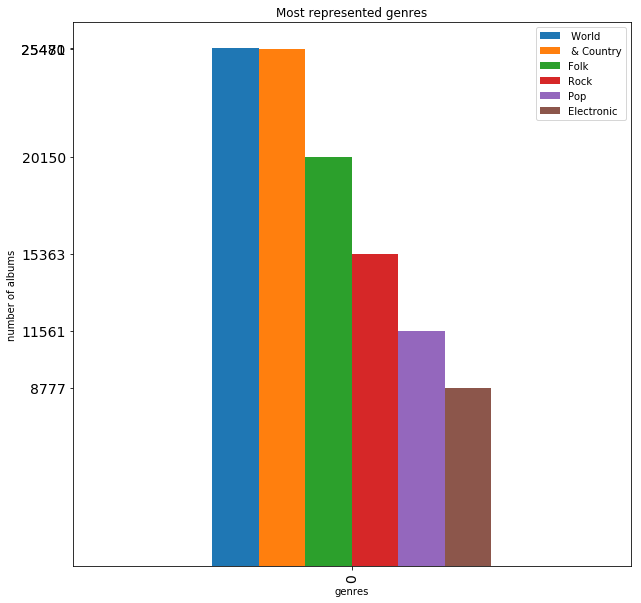

In [12]:
res = execute_query("""SELECT genre, COUNT(*) FROM album_genre GROUP BY genre ORDER BY COUNT(*) DESC LIMIT 6""")

data = {}
for x in res:
    data[x[0]] = [x[1]]
dataframe = pd.DataFrame(data)
fig, axi = plt.subplots(1, 1, figsize=(10,10))
_ = axi.set_xlabel("genres")
_ = axi.set_ylabel("number of albums")
ax = dataframe.plot.bar(ax=axi, fontsize=14, yticks=dataframe.iloc[0], title="Most represented genres")

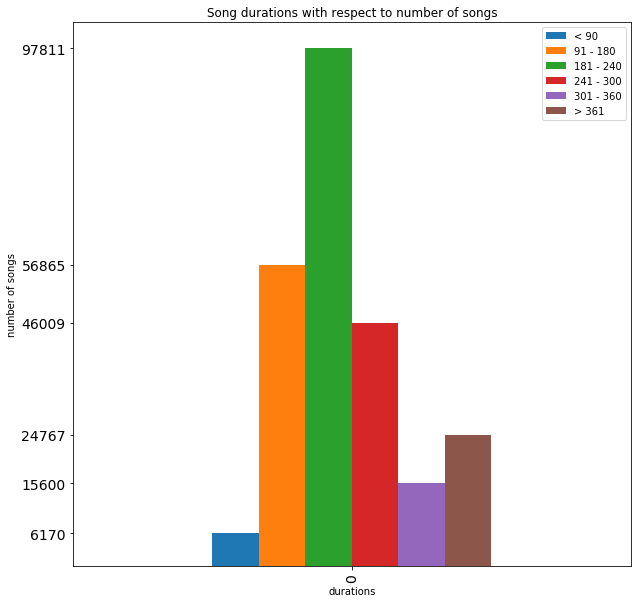

In [13]:
common = """SELECT COUNT(*) FROM track_list WHERE duration BETWEEN {0} AND {1}"""
res1 = execute_query(common.format(1, 90))[0][0]
res91 = execute_query(common.format(91, 180))[0][0]
res181 = execute_query(common.format(181, 240))[0][0]
res240 = execute_query(common.format(241, 300))[0][0]
res300 = execute_query(common.format(301, 360))[0][0]
res360 = execute_query("""SELECT COUNT(*) FROM track_list WHERE duration > 361""")[0][0]

dataframe = pd.DataFrame({'< 90': [res1], '91 - 180': [res91], '181 - 240': [res181], '241 - 300': [res240], '301 - 360': [res300], '> 361': [res360]})
fig, axi = plt.subplots(1, 1, figsize=(10,10))
_ = axi.set_xlabel("durations")
_ = axi.set_ylabel("number of songs")
reg = dataframe.plot.bar(ax=axi, fontsize=14, yticks=dataframe.iloc[0], title="Song durations with respect to number of songs")

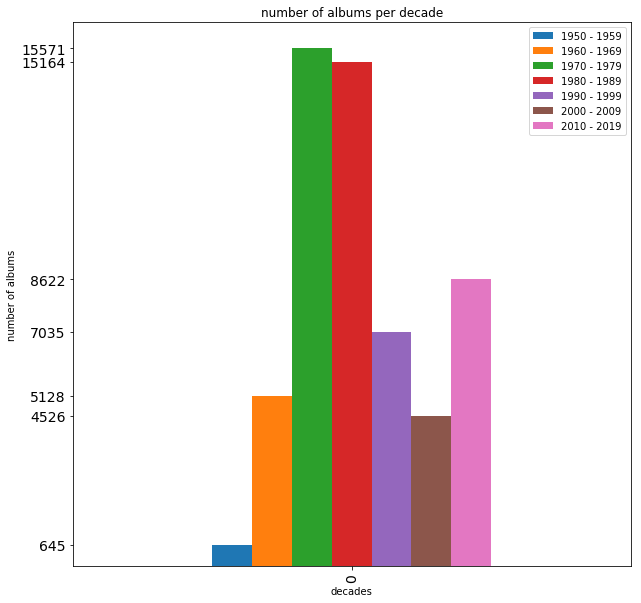

In [14]:
common = """SELECT COUNT(*) FROM album WHERE released BETWEEN '{0}' AND '{1}'"""
res1950 = execute_query(common.format(parser.parse('1.1.1950.'), parser.parse('31.12.1959')))[0][0]
res1960 = execute_query(common.format(parser.parse('1.1.1960.'), parser.parse('31.12.1969')))[0][0]
res1970 = execute_query(common.format(parser.parse('1.1.1970.'), parser.parse('31.12.1979')))[0][0]
res1980 = execute_query(common.format(parser.parse('1.1.1980.'), parser.parse('31.12.1989')))[0][0]
res1990 = execute_query(common.format(parser.parse('1.1.1990.'), parser.parse('31.12.1999')))[0][0]
res2000 = execute_query(common.format(parser.parse('1.1.2000.'), parser.parse('31.12.2009')))[0][0]
res2010 = execute_query(common.format(parser.parse('1.1.2010.'), parser.parse('31.12.2019')))[0][0]

dataframe = pd.DataFrame({'1950 - 1959': [res1950], '1960 - 1969': [res1960], '1970 - 1979': [res1970], '1980 - 1989': [res1980],
                          '1990 - 1999': [res1990], '2000 - 2009': [res2000], '2010 - 2019': [res2010]})

fig, axi = plt.subplots(1, 1, figsize=(10,10))
_ = axi.set_xlabel("decades")
_ = axi.set_ylabel("number of albums")
_ = dataframe.plot.bar(ax=axi, fontsize=14, yticks=dataframe.iloc[0], title="number of albums per decade")

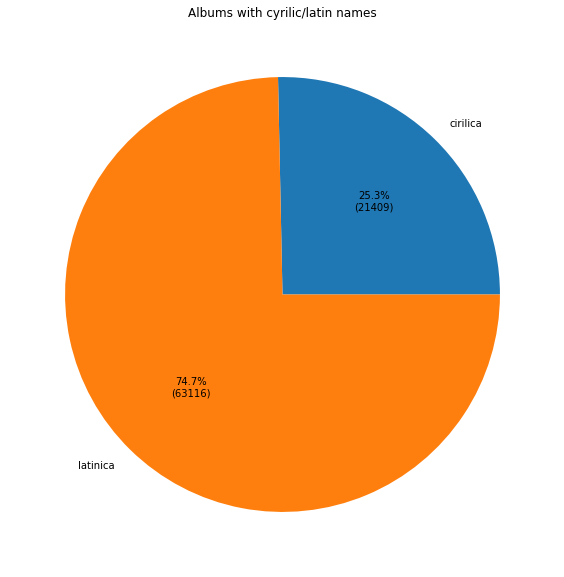

In [15]:
cyrilic_num = execute_query("""SELECT COUNT(*) FROM album WHERE album_name REGEXP '[А-Ша-ш]+' AND album_name REGEXP '[^A-za-z]+'""")[0][0]
latin_num = execute_query("""SELECT COUNT(*) FROM album WHERE album_name REGEXP '[A-Za-z]+' AND album_name REGEXP '[^А-Ша-ш]+'""")[0][0]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
total_count = execute_query("""SELECT COUNT(*) FROM album""")[0][0] 
_ = ax.pie([cyrilic_num, latin_num], labels=['cirilica', 'latinica'], autopct=lambda x: func(x, [cyrilic_num, latin_num]))
_ = ax.set_title("Albums with cyrilic/latin names")

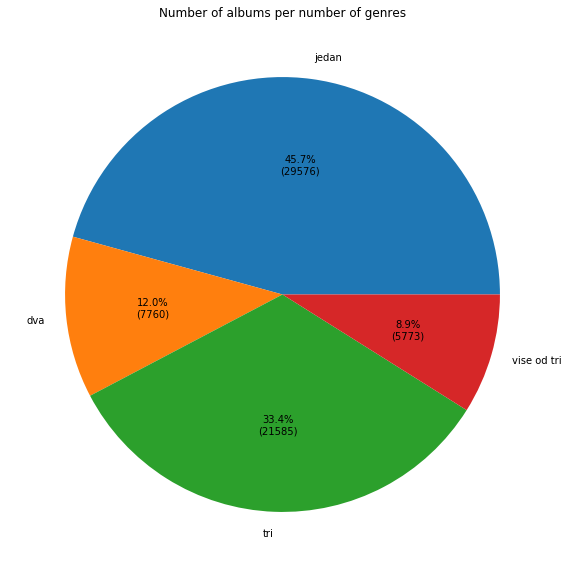

In [16]:
common = """SELECT COUNT(*) FROM (SELECT COUNT(g.album_id) as tmp FROM album_genre g GROUP BY g.album_id HAVING tmp = {0}) x"""
res1 = execute_query(common.format(1))[0][0]
res2 = execute_query(common.format(2))[0][0]
res3 = execute_query(common.format(3))[0][0]
res4 = execute_query("""SELECT COUNT(*) FROM (SELECT COUNT(g.album_id) as tmp FROM album_genre g GROUP BY g.album_id HAVING tmp > 3) x""")[0][0]

fig, axi = plt.subplots(1, 1, figsize=(10,10))
_ = axi.pie([res1, res2, res3, res4], labels=['jedan', 'dva', 'tri', 'vise od tri'], autopct=lambda x: func(x, [res1, res2, res3, res4]))
_ = axi.set_title("Number of albums per number of genres")

In [10]:
cursor.close()
conn.close()

True